# Finding the Z peak using ROOT in Python!

In this analysis, we are focusing on identifying the decay of the [Z bosons](https://en.wikipedia.org/wiki/W_and_Z_bosons), a fundamental particle responsible for mediating the weak nuclear force. Let's get started!

<CENTER>
    <a href="http://opendata.atlas.cern" class="icons"><img src="../../images/ATLASOD.gif" style="width:40%"></a>
</CENTER>

## What is the Z Boson?
The Z boson is one of the mediators of the weak force, which is responsible for processes such as [beta decay](https://en.wikipedia.org/wiki/Beta_decay) in atomic nuclei. It interacts with all known fermions (quarks and leptons), but unlike the W boson, it does not change the type (flavor) of particle it interacts with. The Z boson couples to both [left-handed and right-handed](https://en.wikipedia.org/wiki/Chirality_(physics)) particles, making its behavior distinct from the charged W boson.

Since the Z boson is electrically neutral, its decay products must have balanced charges. The decays of the Z boson into leptons (electrons, muons, and taus) are particularly useful for experimental studies because these particles can be precisely measured in detectors, giving a clear signature of the Z boson's presence.

## The Decay of the Z Boson

The Z boson decays rapidly due to its high mass, with a mean lifetime of around 3 × 10$^{-25}$ seconds. Its decay channels include hadrons (quarks) and leptons, but in this analysis, we are particularly interested in the lepton channels because they produce clean final states that are easier to measure.

In this notebook, we are looking for events where the Z boson decays to:
- Two leptons of the same flavor but opposite charge (e.g., Z → e$^+$e$^-$ or Z → μ$^+$μ$^-$). Showed in the image on the left.
- In some cases, four leptons, which could result from intermediate states. Showed in the image on the right.

<table style="width:100%; text-align:center;">
  <tr>
    <td><img src="../../images/Z_ElectronPositron.png" style="width:65%"></td>
    <td><img src="../../images/fig01a.png" style="width:50%"></td>
  </tr>
</table>


The aim of this analysis is to plot the Z peak, which refers to the resonant mass of the Z boson observed in the invariant mass distribution of the two leptons. By plotting the invariant mass of the two-lepton system, we expect to see a peak around 91 GeV/c², which corresponds to the mass of the Z boson.

## Running a Jupyter notebook
A Jupyter notebook consists of cell blocks, each containing lines of Python code. Each cell can be run independently of each other, yielding respective outputs below the cells. Conventionally,cells are run in order from top to bottom.

- To run the whole notebook, in the top menu click Cell $\to$ Run All.
- To propagate a change you've made to a piece of code, click Cell $\to$ Run All Below.
- You can also run a single code cell, by clicking Cell $\to$ Run Cells, or using the keyboard shortcut Shift+Enter.

For more information, refer to [How To Use Jupyter Notebooks](https://www.codecademy.com/article/how-to-use-jupyter-notebooks).

By the end of this notebook you will be able to:
1. Learn to process large data sets using cuts
2. Understand some general principles of a particle physics analysis
3. Discover the Z boson!

## The analysis

The following section details the steps taken to analyze the Z boson decays from our data sample. The analysis revolves around reading, processing, and visualizing events where the Z boson decays into leptons.

The first step is to import the `ROOT` library, which is essential for handling `.root` files, a widely used data format in High Energy Physics (HEP) for storing large datasets.

In [1]:
import ROOT

To visualize the histogram interactively, we enable the JSROOT magic function. This allows us to display the ROOT histograms directly in the notebook.

In [ ]:
%jsroot on

Next, we open the data file, which contains events collected from particle collisions. These events are stored in `.root` files. You can choose between different datasets:
- The **2-lepton sample**, where events involve two leptons, possibly from Z boson decays.
- The **4-lepton sample**, for more complex events involving four leptons.

In [ ]:
# install required packages. --user is only required in SWAN.
%pip install --user atlasopenmagic

In [ ]:
# Now we have to do a little bit of work to make sure that atlasopenmagic is available in our python path
# This is because SWAN by default does not include the local package installation area in the PYTHONPATH
# Again, this is not necessary on binder or colab
import sys
import os
sys.path += [ f'{os.environ["HOME"]}/.local/lib/python{sys.version_info.major}.{sys.version_info.minor}/site-packages' ]

# Now we can safely import atlasopenmagic
import atlasopenmagic as atom

In [ ]:
# Now let's see what releases are available to us
atom.available_releases()

In [6]:
# And let's plan to use the latest release of Open Data for Outreach and Education
atom.set_release('2025e-13tev-beta')

Fetching and caching all metadata for release: 2025e-13tev-beta...
Fetched 374 datasets so far...
Successfully cached 374 datasets.
Active release: 2025e-13tev-beta. (Datasets path: REMOTE)


In [7]:
## CHOOSE here which sample to use!!

## 2-4 lepton events
file_path = atom.get_urls(key='700320', skim='2to4lep', protocol='root')[0]

## 2-4 lepton events via the https protocol in case xrootd is unavailable
#file_path = atom.get_urls(key='700320', skim='2to4lep', protocol='https', cache = True)[0]

f = ROOT.TFile.Open(file_path) 

print(file_path)

root://eospublic.cern.ch:1094//eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_2to4lep_mc_700320.Sh_2211_Zee_maxHTpTV2_BFilter.2to4lep.root


In ROOT, we use a canvas to hold and display graphical objects such as histograms. Here, we create a canvas named Canvas, and define its size to be 800x600 pixels.

In [8]:
canvas = ROOT.TCanvas("Canvas","c",800,600)

The data is stored in a TTree, which contains events and variables that describe particle kinematics, charges, and types. We access the tree and count the number of entries (events) in it.

In [9]:
tree = f.Get("analysis")
tree.GetEntries()

2469788

A histogram is created to store the invariant mass distribution of the Z boson decay products. This histogram is binned into 30 intervals, ranging from 40 GeV to 140 GeV on the x-axis (mass), while the y-axis represents the number of events. This range is centered around the Z boson mass (~91 GeV).

In [10]:
hist = ROOT.TH1F("variable","Mass of the Z boson; mass [GeV]; events",30,40,140)

To fill the histogram, we loop over each event in the TTree, applying several cuts to select the events of interest. The goal is to isolate Z boson decays into two leptons:

- **Cut #1: At least two leptons**. This ensures that the event contains two leptons, which are necessary for reconstructing the Z boson mass.
- **Cut #2: Opposite charge leptons**. Since the Z boson is neutral, it decays into a lepton and its antiparticle (opposite charge).
- **Cut #3: Same lepton family**. We select events where both leptons are either electrons (Z → e$^+$e$^-$) or muons (Z → μ$^+$μ$^-$).

For each event passing the cuts, we calculate the invariant mass using the four-momenta of the leptons and fill the histogram.

In [11]:
leadLepton  = ROOT.TLorentzVector()
trailLepton = ROOT.TLorentzVector()

for event in tree:
    
    # Cut #1: At least 2 leptons
    if tree.lep_n >= 2:
        
        # Cut #2: Leptons with opposite charge
        if (tree.lep_charge[0] != tree.lep_charge[1]):
            
            # Cut #3: Leptons of the same family (2 electrons or 2 muons)
            if (tree.lep_type[0] == tree.lep_type[1]):
                
                # Define Lorentz vectors for both leptons
                leadLepton.SetPtEtaPhiE(tree.lep_pt[0], tree.lep_eta[0], tree.lep_phi[0], tree.lep_e[0])
                trailLepton.SetPtEtaPhiE(tree.lep_pt[1], tree.lep_eta[1], tree.lep_phi[1], tree.lep_e[1])
                
                # Invariant mass calculation (dividing by 1000 to convert to GeV)
                invmass = leadLepton + trailLepton
                
                hist.Fill(invmass.M())

Once the histogram is filled, we can visualize it. We use the Draw() method to display the histogram on the canvas. Additionally, we set the fill color of the histogram for better visibility.

In [12]:
hist.Draw()
hist.SetFillColor(3)

Finally, we render the canvas to display the results of our analysis, showing the invariant mass distribution of the Z boson decay products.

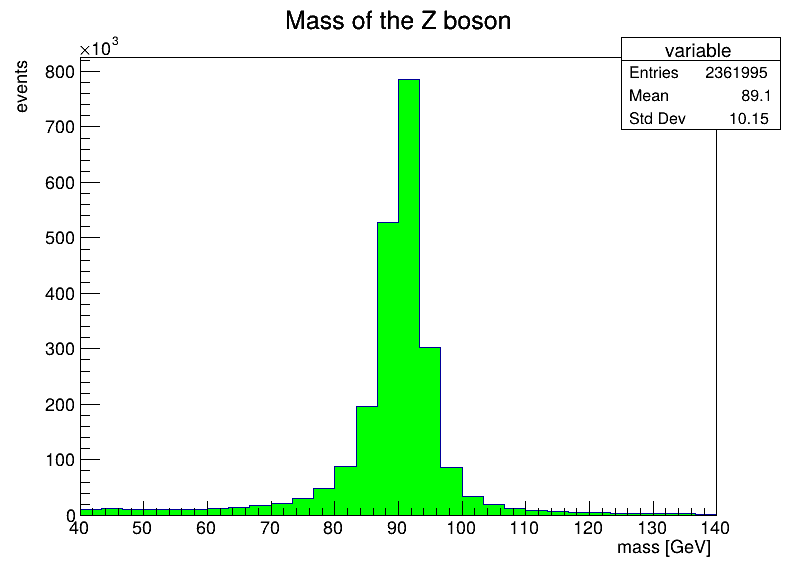

Info in <TCanvas::Print>: png file Zll_inv_mass.png has been created


In [13]:
# canvas.Draw()

# If you want a copy of your plot locally, uncomment the following line
# c.SaveAs("Zll_inv_mass.pdf") # pdf image

from IPython.display import Image, display

# Save the canvas as a PNG
canvas.SaveAs("Zll_inv_mass.png")

# Display inside the notebook so it gets stored in the output
display(Image(filename="Zll_inv_mass.png"))

## Understanding the plot

The plot above represents the invariant mass distribution of two leptons (electrons or muons) produced in the decay of the Z boson. This histogram was filled by calculating the invariant mass of pairs of leptons (with opposite charge and same flavor) from the dataset, with 30 bins covering a mass range from 40 to 140 GeV.

This is what we are looking at in the plot:

- **Z Peak at ~91 GeV**: The prominent peak at around 91 GeV corresponds to the mass of the Z boson, which is well-known to be approximately 91 GeV/c$^2$. This peak is the result of many events where a Z boson was produced and decayed into a lepton-antilepton pair (Z → l$^+$l$^-$, where l = e, μ). The number of entries (2,361,995) reflects the number of such events detected and analyzed in this dataset.
- **Mean and Standard Deviation**:
    - **Mean Mass**: The mean of the distribution is 89.10 GeV, very close to the expected mass of the Z boson.
    - **Standard Deviation** (10.15 GeV): This value reflects the width of the mass distribution. The spread around the peak is due to experimental resolution, detector effects, and the natural width of the Z boson (~2.5 GeV). The broader standard deviation may also reflect the complexity of the event reconstruction and the simplicity of this analysis.
- **Low and High-Mass Tails**: The tails of the distribution, extending below 80 GeV and above 100 GeV, correspond to background events. These can arise from misidentified or non-resonant processes that do not involve the Z boson but still produce lepton pairs. Events outside the Z boson peak range may come from processes such as Drell-Yan or other electroweak backgrounds.
- **Y-Axis** (Events): The y-axis shows the number of events in each bin, which indicates how many events with a given invariant mass were observed. The highest point of the peak corresponds to the most frequent mass value for Z boson decays, which is around 91 GeV.